In [1]:
%load_ext autoreload
%autoreload 2
from func.utils import get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename
from glob import glob
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm
from train_prophet import main_prophet
import datetime
import math
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set()

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET]

train_paths = glob('../feature/raw_main/*_train.gz')
test_paths = glob('../feature/raw_main/*_test.gz')

train_paths = [path for path in train_paths if path.count('DT') or path.count('day_no') or path.count('Amt')]
test_paths  = [path for path in test_paths  if path.count('DT') or path.count('day_no') or path.count('Amt')]

train_df = parallel_load_data(train_paths)
test_df = parallel_load_data(test_paths)

In [31]:
START_DATE = '2017-11-04'
# START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
train_df['datetime'] = train_df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test_df['datetime'] = test_df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

train_df['month'] = train_df['datetime'].map(lambda x: x.month)
test_df['month']  =  test_df['datetime'].map(lambda x: x.month)
train_df['date'] = train_df['datetime'].map(lambda x: x.date())
test_df['date']  =  test_df['datetime'].map(lambda x: x.date())

tmp_train_df = train_df[train_df['month']!=12]
tmp_test_df = test_df[test_df['month']!=12]

train = tmp_train_df[['date', 'TransactionAmt']].set_index('date')
test  = tmp_test_df[['date', 'TransactionAmt']].set_index('date')

data = pd.concat([train, test], axis=0)

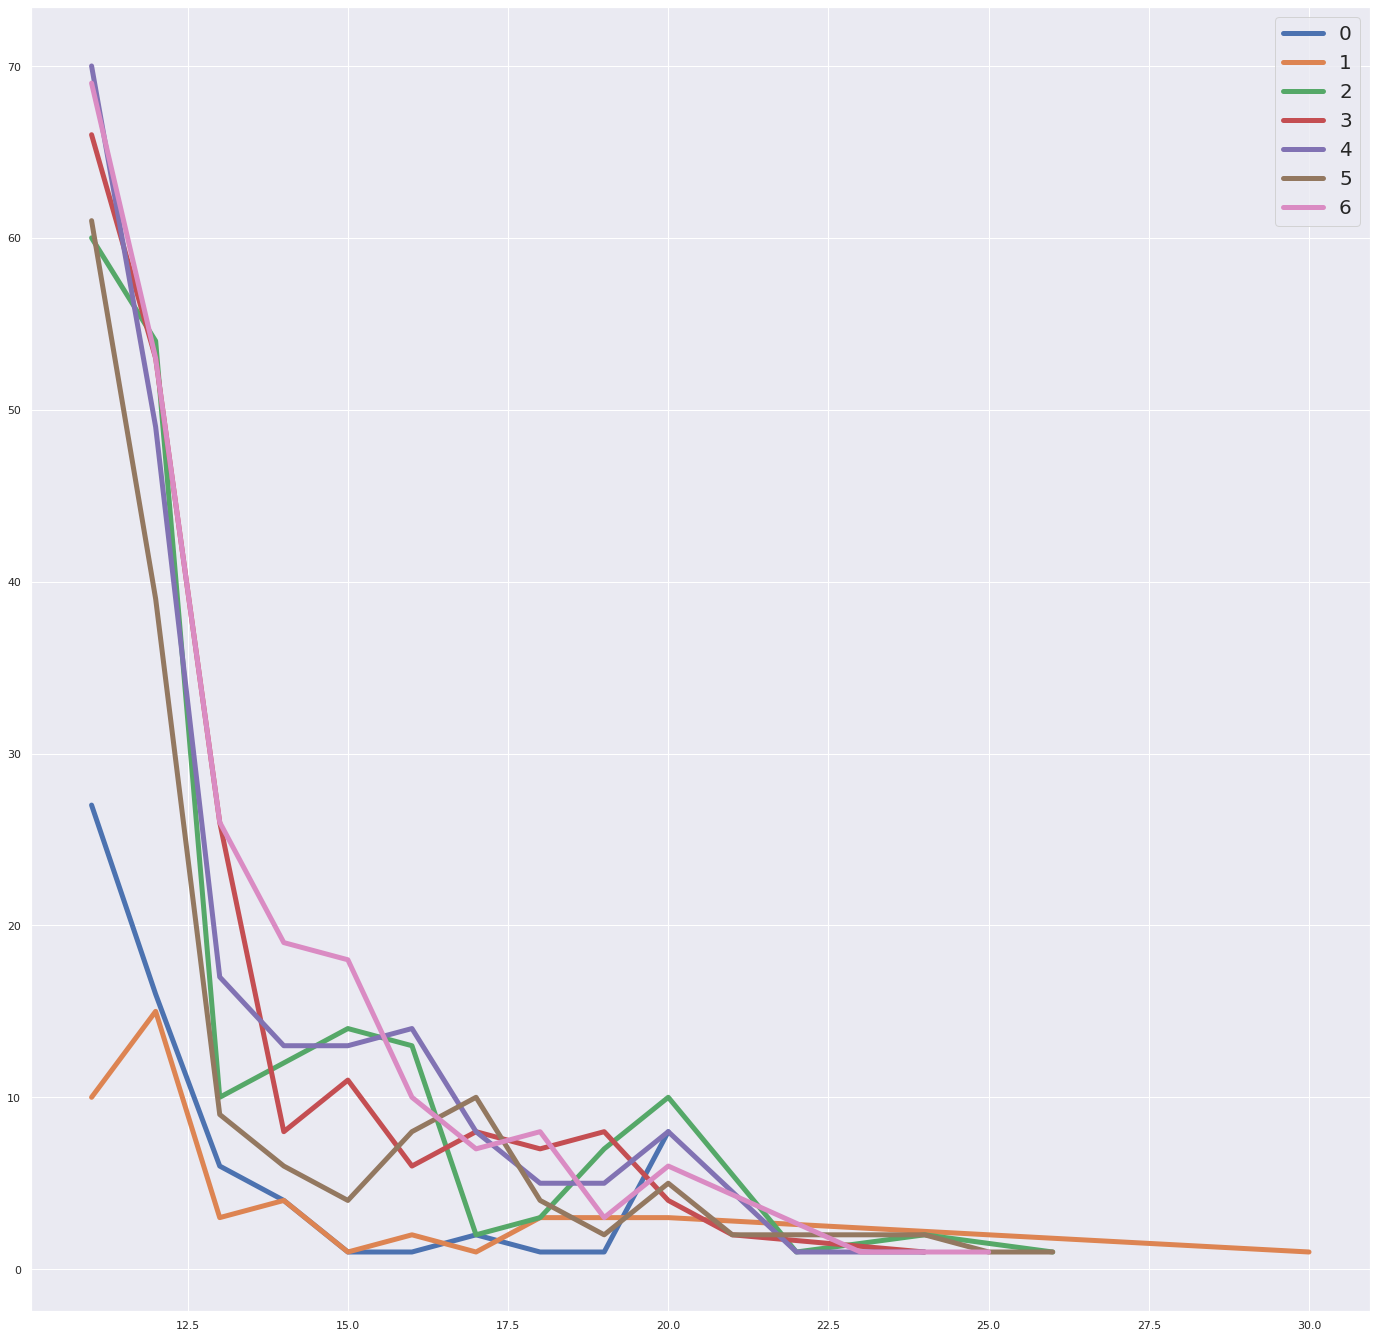

In [29]:
# indicator = 'TransactionAmt_max'
indicator = 'TransactionAmt'
# pd.set_option('max_rows', 200)
data = (data-data.mean())/data.std()
# tmp = (data - data.shift(-1)).round(1)
tmp = data
tmp = tmp.reset_index()
tmp['dow'] = tmp['date'].map(lambda x: x.weekday())
tmp['month'] = tmp['date'].map(lambda x: x.month)
# pd.concat([
# tmp.groupby('dow')[ indicator].median()
# ,tmp.groupby('dow')[indicator].mean()
# ,tmp.groupby('dow')[indicator].max()
# ,tmp.groupby('dow')[indicator].min()
# ], axis=1)
tmp[indicator] = tmp[indicator].round(0)
dow_list = sorted(tmp['dow'].unique())
sns.set_style('whitegrid')
viz_list = []
plt.figure(figsize=(24, 24))
for dow in dow_list:
    df = tmp[tmp['dow']==dow]
    viz = df[indicator].value_counts().sort_index().reset_index()
    viz = viz[viz['index']>10]
    viz = viz[viz['index']<35]
    viz['dow'] = dow
    
    sns.set()
    fig = plt.plot(viz['index'], viz[indicator], label=dow, lw=5)
#     viz_list.append(viz)
# viz = pd.concat(viz_list, axis=0)
# plt.figure(figsize=(24, 8))
# sns.set()
# # sns.lineplot(data=viz, x='index', y =indicator, hue='dow', lw="3")
# plt.plot(viz['index'], viz[indicator])
plt.legend(fontsize=20)
plt.show()

In [33]:
indicator ='transaction_cnt' 

train = train_df.groupby('date')['date'].count()
train.name = indicator
test = test_df.groupby('date')['date'].count()
test.name = indicator

data = pd.concat([train, test], axis=0)

In [37]:
tmp = (data - data.mean())/data.std()
tmp.tail(60)

date
2018-10-27    0.736038
2018-10-28    0.779415
2018-10-29   -0.339723
2018-10-30   -0.876363
2018-10-31   -0.197197
2018-11-01   -0.352116
2018-11-02   -0.577679
2018-11-03   -0.737556
2018-11-04   -0.146383
2018-11-05   -0.721444
2018-11-06   -1.172569
2018-11-07   -0.679306
2018-11-08   -0.546695
2018-11-09   -0.365749
2018-11-10   -0.136468
2018-11-11    0.136190
2018-11-12   -0.345919
2018-11-13   -0.821832
2018-11-14    0.034563
2018-11-15   -0.329808
2018-11-16   -0.038559
2018-11-17   -1.196117
2018-11-18   -0.587594
2018-11-19   -0.743752
2018-11-20   -0.975512
2018-11-21    0.375385
2018-11-22    0.174610
2018-11-23   -0.187282
2018-11-24   -0.270319
2018-11-25    0.964079
2018-11-26    0.401412
2018-11-27   -0.089373
2018-11-28    1.437513
2018-11-29    1.034722
2018-11-30    0.211791
2018-12-01    0.239056
2018-12-02    0.773218
2018-12-03    0.099009
2018-12-04   -0.282712
2018-12-05    0.607145
2018-12-06    0.749671
2018-12-07    0.555092
2018-12-08    0.464619
2018-1

In [ ]:
for col in ['day_no', 'hour', 'time_zone', 'month']:
    feature = train_df[col].values
    to_pkl_gzip(obj=feature, path=f'../feature/raw_main/{col}_train')

for col in ['day_no', 'hour', 'time_zone', 'month']:
    feature = test_df[col].values
    to_pkl_gzip(obj=feature, path=f'../feature/raw_main/{col}_test')

In [96]:
START_DATE = '2017-12-01'

for START_DATE in [
    '2017-11-25',
#     '2017-11-29',
#     '2017-11-30',
#     '2017-12-01',
]:

    startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
    train_df['datetime'] = train_df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
    test_df['datetime'] = test_df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
    
    train_df['date'] = train_df['datetime'].map(lambda x: x.date())
    test_df['date']  =  test_df['datetime'].map(lambda x: x.date())
    
    train = train_df.groupby('date')['date'].count()
    train.name = 'transaction_cnt'
    test = test_df.groupby('date')['date'].count()
    test.name = 'transaction_cnt'
    train = train.reset_index()
    test = test.reset_index()
    train['day_of_week'] = train['date'].map(lambda x: x.weekday())
    test['day_of_week'] = test['date'].map(lambda x: x.weekday())
    train = pd.concat([train, test], axis=0, ignore_index=True)
    
    train['month'] = train['date'].map(lambda x: x.month)
    test['month'] = test['date'].map(lambda x: x.month)
    train = train[train['month']!=11]
    train = train[train['month']!=12]
    train = train[train['month']!=1]
    train = train[train['month']!=3]
    print(train['month'].value_counts())
    
    pred_period = 200
    trend_term = 'monthly'
    TARGET = 'transaction_cnt'
    
    pred_df = main_prophet(
        train = train,
        test = [],
        COLUMN_TARGET = TARGET,
        ADD_FEATURES = [],
        pred_period = pred_period,
        trend_term = trend_term,
        is_viz = False,
        is_score = False,
        holidays=[],
    )
    display(pred_df.groupby('day_of_week')['weekly'].max())

10    31
8     31
7     31
9     30
4     30
2     28
5     26
6      5
Name: month, dtype: int64


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


day_of_week
0.0   -238.002966
1.0   -498.714017
2.0     77.571352
3.0    120.962994
4.0    101.196135
5.0     70.491257
6.0    366.495245
Name: weekly, dtype: float64